## DATA FORMAT

The purpose of this notebook to prepare a data format for futher analysis as well as to create initial EDA. Note the analysis will be used only for single example. The portfolio EDA will established when data format is ready

In [38]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append(os.getcwd() + "/..")
from utils import plot_correlogram
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [2]:
meta, data =pd.read_pickle("../data/forecast_data_2020.p")

## Transform Data (Single Sample)

In [3]:
homes_indexes = data.columns.get_level_values(0).unique()

In [4]:
df = data["123"].copy(deep=True)
for col in df.columns:
    df[col] = df[col].astype(float)

In [5]:
df.shape

(8809, 4)

In [6]:
pd.Series(df.index).value_counts()

2020-09-08 16:00:00    2
2020-09-08 08:00:00    2
2020-09-07 23:00:00    2
2020-09-08 00:00:00    2
2020-09-08 01:00:00    2
                      ..
2020-05-01 18:00:00    1
2020-05-01 17:00:00    1
2020-05-01 16:00:00    1
2020-05-01 15:00:00    1
2021-01-01 00:00:00    1
Name: time, Length: 8785, dtype: int64

In [7]:
# NOTE, currenctly we dropping all duplicates expect the last duplicate, might in certain cases better to keep
# the index with largest/smallest/avg consumption depence on the risk tolerance
df = df.reset_index().drop_duplicates(subset='time', keep='last').set_index("time")

In [8]:
df.shape

(8785, 4)

In [9]:
def create_window_index_for_agg_over(indexes,
                                     cycle_val=0, # corresponds that full cycle is from 00:00 to 23:00
                                     attr_name="hour"
                                     ):
    agg_index = []
    cur_index = indexes[0].date()
    for i in indexes:
        if getattr(i,attr_name) == cycle_val:
            cur_index = i.date()
        agg_index.append(cur_index)
    return agg_index

In [10]:
%timeit pd.Series(create_window_index_for_agg_over(df.index))

23 ms ± 93.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
df["agg_index"] = create_window_index_for_agg_over(df.index)
df["agg_index"].value_counts()

2020-01-01    24
2020-09-09    24
2020-09-07    24
2020-09-06    24
2020-09-05    24
              ..
2020-04-30    24
2020-04-29    24
2020-04-28    24
2020-04-27    24
2021-01-01     1
Name: agg_index, Length: 367, dtype: int64

In [12]:
df.head(48)

,temperature,humidity,cloudiness,consumption,agg_index
time,,,,,
2020-01-01 00:00:00,4.31,72.0,99.0,4.127,2020-01-01
2020-01-01 01:00:00,4.60,73.0,99.0,4.148,2020-01-01
2020-01-01 02:00:00,4.50,75.0,100.0,3.828,2020-01-01
2020-01-01 03:00:00,4.64,75.0,96.0,4.375,2020-01-01
2020-01-01 04:00:00,4.48,75.0,100.0,4.622,2020-01-01
2020-01-01 05:00:00,4.28,74.0,100.0,4.219,2020-01-01
2020-01-01 06:00:00,4.00,74.0,100.0,3.832,2020-01-01
2020-01-01 07:00:00,4.10,73.0,100.0,4.431,2020-01-01
2020-01-01 08:00:00,4.15,72.0,100.0,5.015,2020-01-01


In [13]:
not_full_cycle_index = df["agg_index"].value_counts()[df["agg_index"].value_counts() != 24].index

In [14]:
df = df[df["agg_index"] != not_full_cycle_index[0]]

In [15]:
df.groupby("agg_index")["consumption"].sum()

agg_index
2020-01-01    92.775
2020-01-02    54.600
2020-01-03    68.860
2020-01-04    90.112
2020-01-05    84.545
               ...  
2020-12-27    57.244
2020-12-28    98.480
2020-12-29    76.199
2020-12-30    60.747
2020-12-31    81.437
Name: consumption, Length: 366, dtype: float64

## Univariate EDA

In [45]:
consumption = pd.DataFrame(df.groupby("agg_index")["consumption"].sum())

temperature = pd.DataFrame({"avg_temperature": df.groupby("agg_index")["temperature"].mean(),
                            "min_temperature": df.groupby("agg_index")["temperature"].min(),
                            "max_temperature": df.groupby("agg_index")["temperature"].max()})

humidity = pd.DataFrame({"avg_humidity": df.groupby("agg_index")["humidity"].mean(),
                         "min_humidity": df.groupby("agg_index")["humidity"].min(),
                         "max_humidity": df.groupby("agg_index")["humidity"].max()})

cloudiness = pd.DataFrame({"avg_cloudiness": df.groupby("agg_index")["cloudiness"].mean(),
                           "min_cloudiness": df.groupby("agg_index")["cloudiness"].min(),
                           "max_cloudiness": df.groupby("agg_index")["cloudiness"].max()})

### Consumption

<AxesSubplot:xlabel='agg_index'>

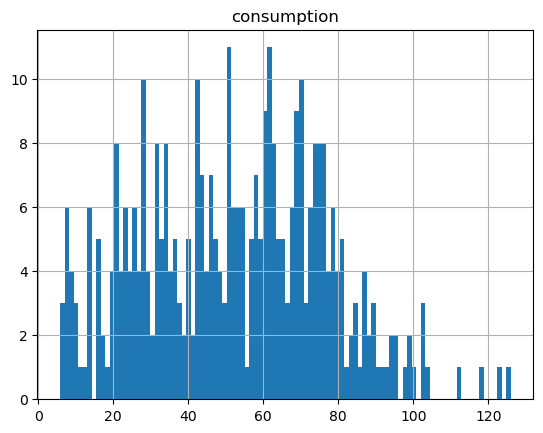

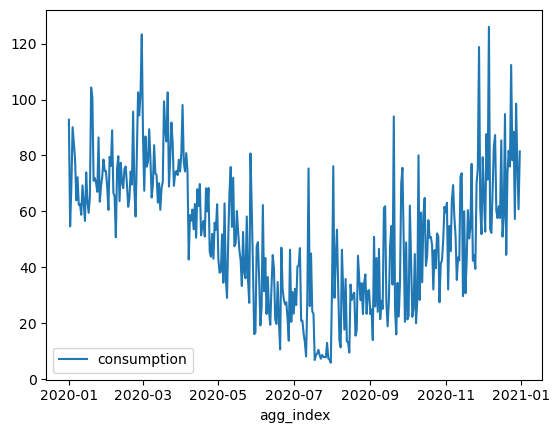

In [17]:
consumption.hist(bins=100)
consumption.plot()

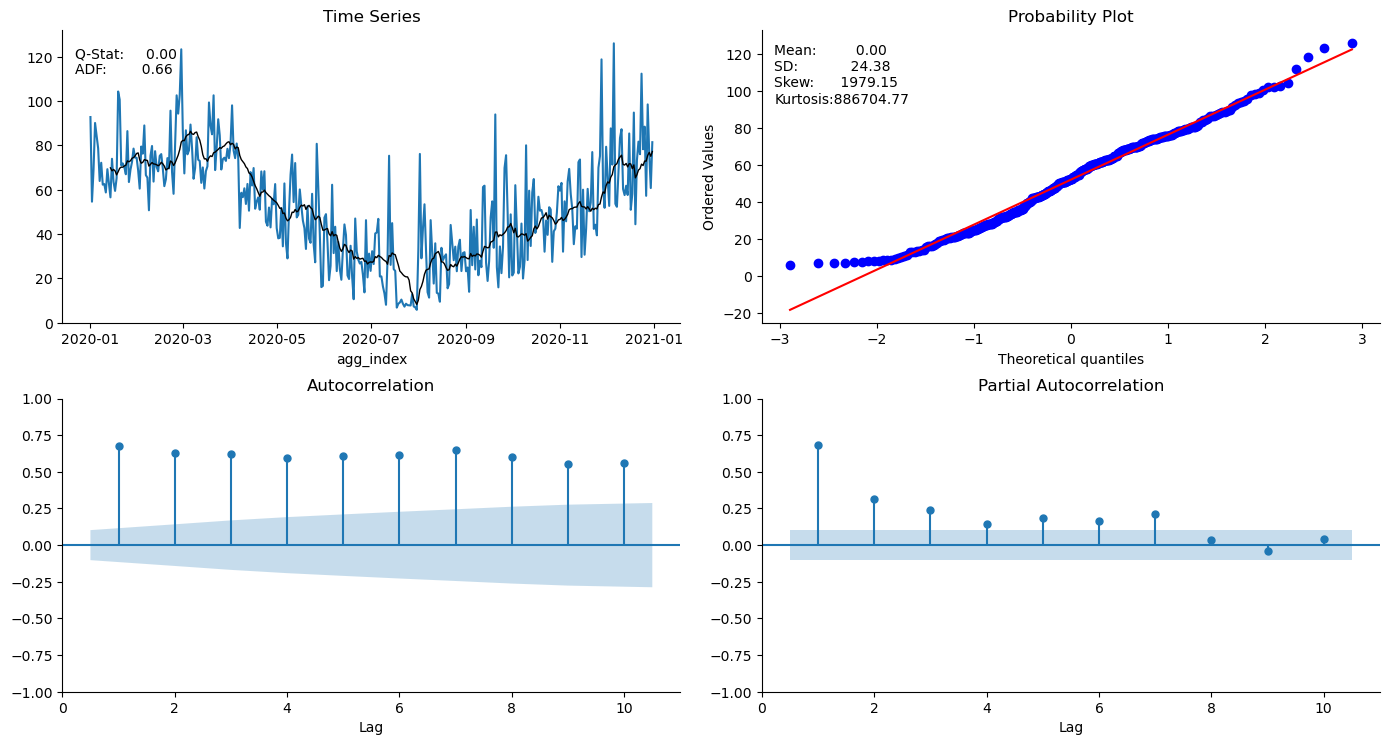

In [28]:
plot_correlogram(consumption["consumption"])

In [69]:
model=pm.auto_arima(consumption["consumption"],start_p=0, d = 0, start_q=0,
                    max_p=10,max_d=1,max_q=0,
                    m=12, seasonal=False,
                    error_action='warn',trace=True,
                    supress_warnings=True,stepwise=True,
                    random_state=20,n_fits=10)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4007.621, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3205.278, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3143.489, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3114.151, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3099.154, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3118.273, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3092.089, Time=0.27 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=3081.175, Time=0.21 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=3072.521, Time=0.24 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=3057.227, Time=0.46 sec
 ARIMA(8,0,0)(0,0,0)[0] intercept   : AIC=3058.288, Time=0.52 sec
 ARIMA(7,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(7,0,0)(0,0,0)[0] intercept
Total fit time: 2.592 seconds


In [70]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(7, 0, 0)   Log Likelihood               -1519.613
Date:                Sun, 02 Oct 2022   AIC                           3057.227
Time:                        14:01:41   BIC                           3092.350
Sample:                             0   HQIC                          3071.184
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.0676      2.300      1.768      0.077      -0.441       8.576
ar.L1          0.2647      0.048      5.513      0.000       0.171       0.359
ar.L2          0.0918      0.049      1.858      0.0

### Temperature

<AxesSubplot:xlabel='agg_index'>

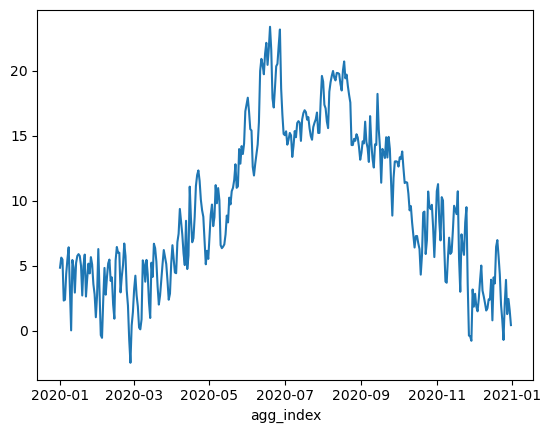

In [58]:
temperature["avg_temperature"].plot()

<AxesSubplot:>

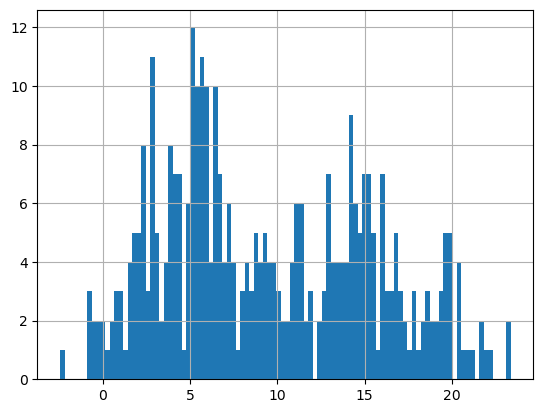

In [59]:
temperature["avg_temperature"].hist(bins=100)

### Humidity

<AxesSubplot:xlabel='agg_index'>

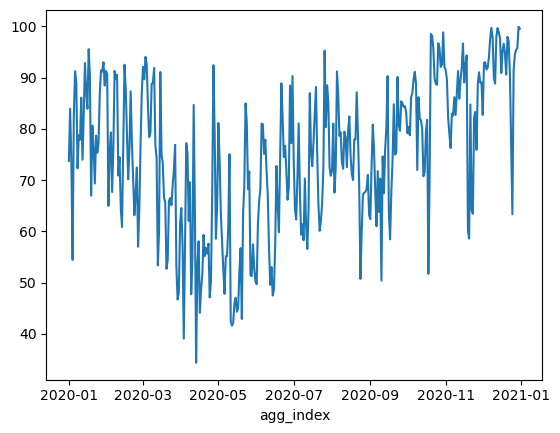

In [61]:
humidity.avg_humidity.plot()

<AxesSubplot:>

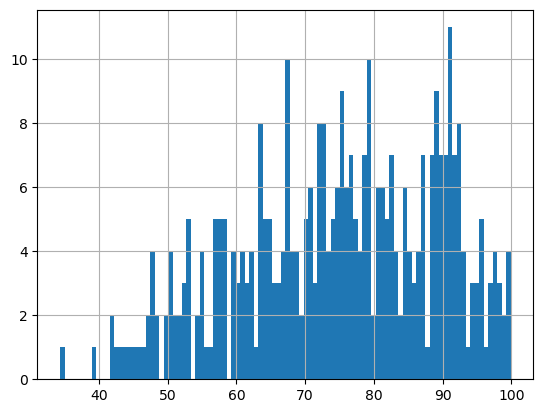

In [62]:
humidity.avg_humidity.hist(bins=100)

### Cloudiness

<AxesSubplot:xlabel='agg_index'>

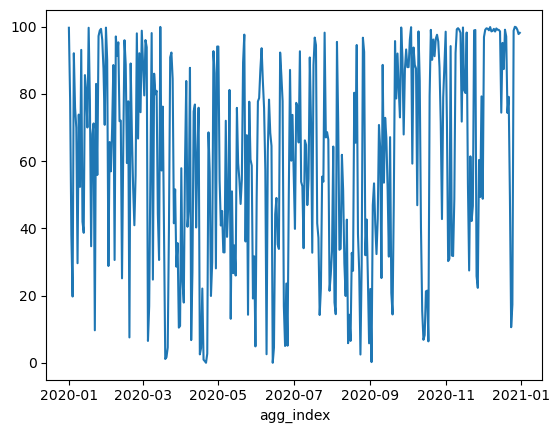

In [63]:
cloudiness["avg_cloudiness"].plot()

<AxesSubplot:>

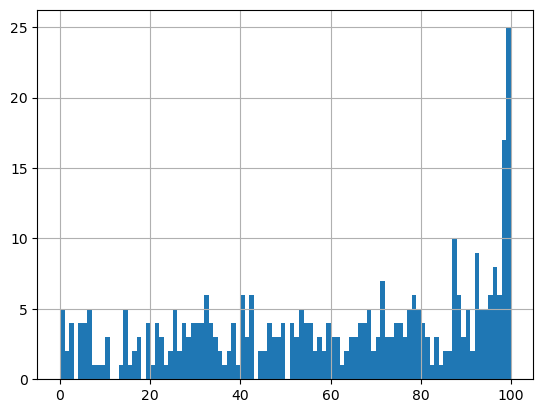

In [64]:
cloudiness["avg_cloudiness"].hist(bins=100)

#### Result based on singgle sample
1) consumption - not all lags are significant at 5% level, adding MA component won't increase in sample AIC much. Did not include seasonal componet since the data just represent a yearly cycle

2) temperature - might be will require to create a buckets

3) avg_humidity - might be will require to create a buckets

4) cloudiness - most of the density are on the right part of the distribution, buckets might help

## Multivariate EDA

shift operations:
1) At time step t we need to make prediction for t+1 using the consumption on t-1:
   thus consumption will be shifted by 2 (forward)
2) Since the weather forecast is avaiable for t+1 is avaiable at t:
   thus all weather variables will be shifted by -1 (backward)

In [97]:
target_name = "consumption_(t+1)"
data_consumption = pd.DataFrame({
                      "consumption_(t-1)": consumption.consumption,
                      target_name: consumption.consumption.shift(-2)})
weather = pd.concat([temperature,humidity, cloudiness], axis=1).shift(1)

data_full = pd.concat([data_consumption, weather], axis=1).dropna()

<AxesSubplot:>

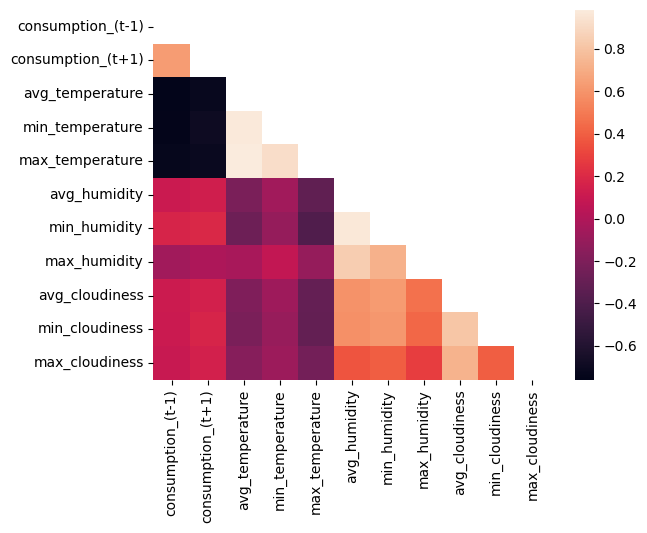

In [98]:
corr = data_full.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask)

<AxesSubplot:>

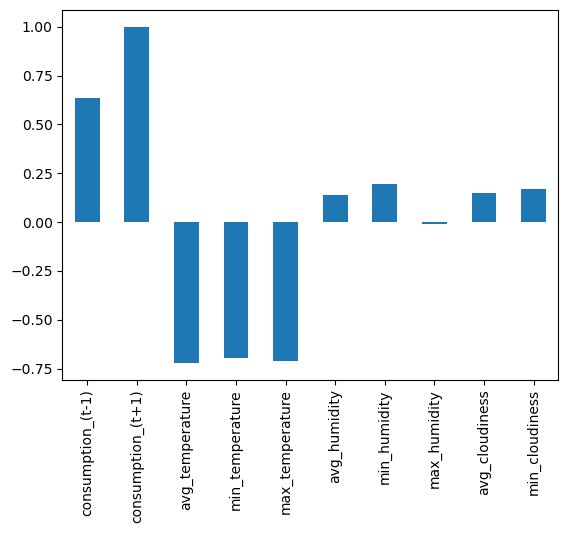

In [101]:
corr = data_full.corr(method='pearson')
corr[target_name].iloc[:-1].plot.bar()

In [103]:
data_full.columns

Index(['consumption_(t-1)', 'consumption_(t+1)', 'avg_temperature',
       'min_temperature', 'max_temperature', 'avg_humidity', 'min_humidity',
       'max_humidity', 'avg_cloudiness', 'min_cloudiness', 'max_cloudiness'],
      dtype='object')

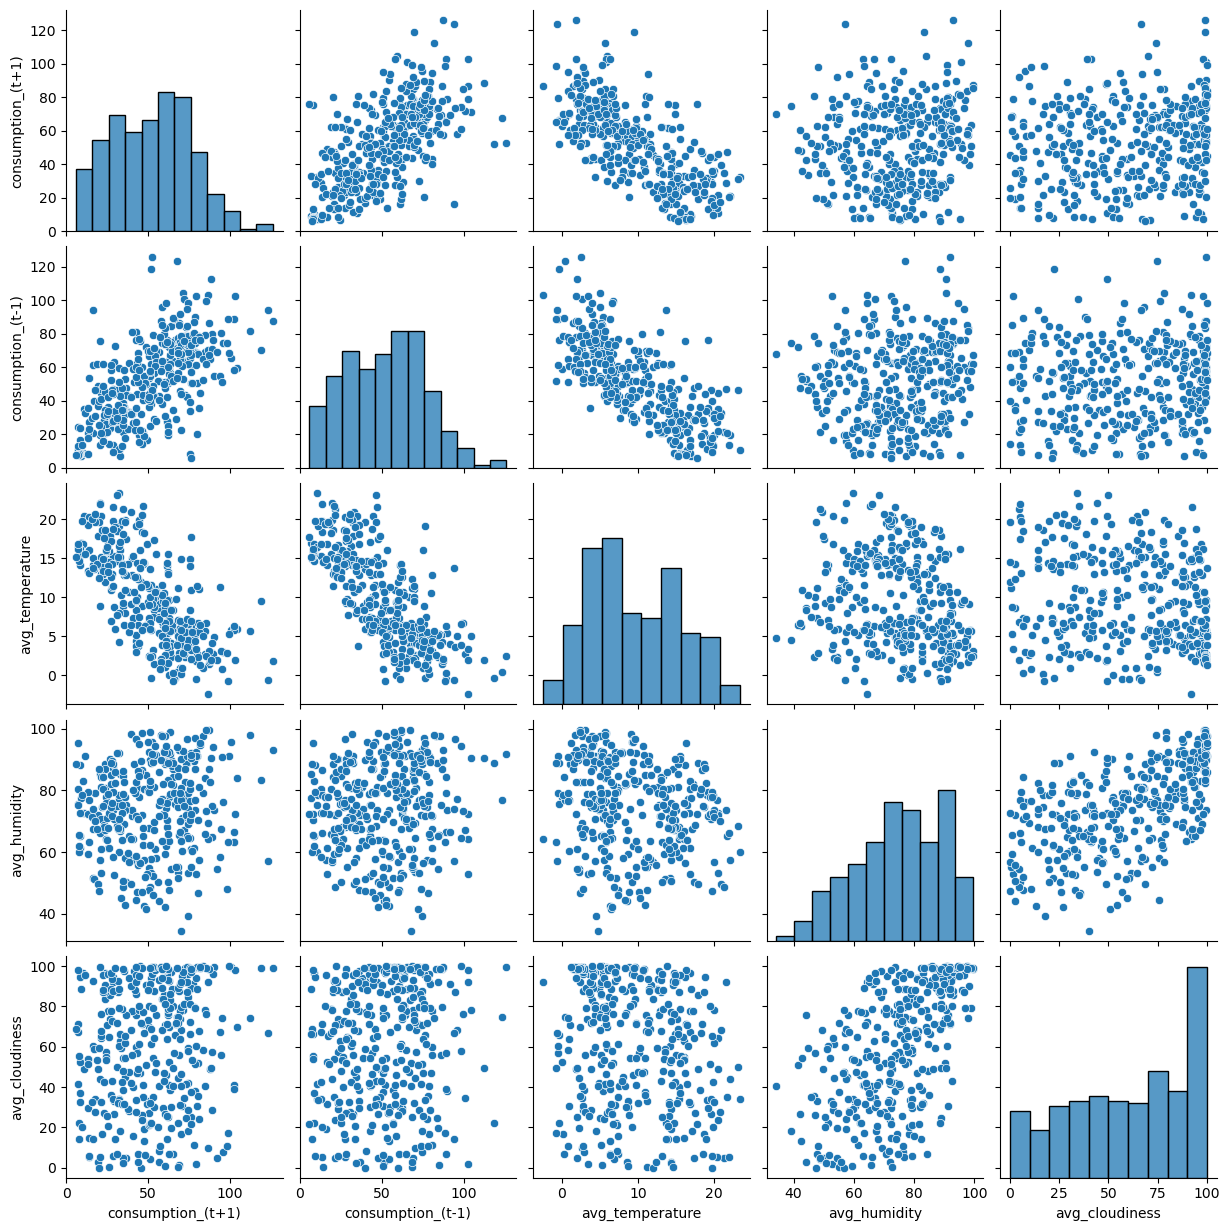

In [105]:
sns.pairplot(data_full[['consumption_(t+1)','consumption_(t-1)',
                       'avg_temperature','avg_humidity','avg_cloudiness']])

## NEXT STEPS
1) Formolize above to generate a data for all samples (homes)
2) Include EV into features (binary)
3) Find if there exists any anomalies, since at the current stage there is no guarantee, that
   data comes from single location, thus it might require to cluster or drop anomalies, the 
   feature temperature could help us to estimate it
4) Using Clasical time Series model such as S/AR/I/MA/X family might be a problematic, since
   the goal is to predict a portfolio consumption not for single home, and we do not want to
   fit a multiple models and then aggreate the result (it will be complicated to maintain N     models in prod)   
5) Given above point 4, we will transform a problem from time-series model to tabular data type model
6) As the base estimator we will use Martingale Process E[X_{t+1}| F_{t}] = X_{t}
7) At current stage we will proceed to experiment with Linear Regression, Random Forest and Gradient Boosting
8) The best model will be chosen depending on Metric (MAPE) and complexity
9) Some features might will require to be bucketized